# Tracking and Predicting Corona Virus

> **Authors**
- [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)
- [Peifan Wu *UBC*](https://economics.ubc.ca/faculty-and-staff/peifan-wu/)


**Prerequisites**

- [Regression](regression.ipynb)  
- [Data Visualization: Rules and Guidelines](visualization_rules.ipynb)  


**Outcomes**

- TODO  

## Outline

- [Tracking and Predicting Corona Virus](#Tracking-and-Predicting-Corona-Virus)  
  - [Introduction](#Introduction)  
  - [Data](#Data)  
  - [Visualization](#Visualization)  
  - [World Bank Data](#World-Bank-Data)  
  - [Predicting growth rates](#Predicting-growth-rates)  
  - [More Detailed Data](#More-Detailed-Data)  
  - [Visualization, continued](#Visualization,-continued)  
  - [References](#References)  
  - [Exercises](#Exercises)  

In [1]:
# Uncomment following line to install on colab
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

## Introduction

This notebook works with daily data on Covid-19 cases by country and region.
There are a few visualizations and an attempt to predict case growth rates.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, preprocessing
)
from pandas_datareader import wb # Use WorldBank data from pandas-datareader

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

/home/paul/.local/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Data

We will use data from [Johns Hopkins University Center for Systems
Science and
Engineering](https://github.com/CSSEGISandData/COVID-19) . It is
gathered from a variety of sources and updated daily. JHU CSSE uses
the data for [this interactive
website.](https://coronavirus.jhu.edu/map.html)

JHU CSSE has the data on github. It gets updated daily.

There are three csv files containing daily counts of confirmed cases,
recoveries, and deaths for each country (and provinces within some
countries).

In [3]:
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
recoveries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,70,75,82,114,147,177,212,272,322,411
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,701,773,839,825,878,889,924,963,1007
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,200,212,226,243,266,313,345,385,432
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,197,238,428,566,673,790,900,1030,1183


The data comes in “wide” format with one row per area and different
dates in columns. Let’s reshape to “long” format with one country-date
combination per row and counts in a single column.

In [4]:
ids = ["Province/State","Country/Region", "Lat","Long"]
confirmed=confirmed.melt(id_vars=ids, var_name="Date", value_name="cases")
deaths=deaths.melt(id_vars=ids,var_name="Date", value_name="deaths")
recoveries=recoveries.melt(id_vars=ids,var_name="Date", value_name="recoveries")

We can now merge the confirmed cases, recoveries, and deaths into a
single data frame.

In [5]:
covid = pd.merge(confirmed, deaths, on=ids.append("Date"))
covid = pd.merge(covid, recoveries, on=ids.append("Date"))

covid["Date"] = pd.to_datetime(covid["Date"])
covid["Province/State"]=covid["Province/State"].fillna("")

We can see the most recent data for Canada with the following.

In [6]:
covid.groupby("Country/Region").get_group("Canada").groupby("Province/State").tail(1)

,Province/State,Country/Region,Lat,Long,Date,cases,deaths,recoveries
28443,British Columbia,Canada,49.2827,-123.1207,2020-03-21,424,10,4
28530,Ontario,Canada,51.2538,-85.3232,2020-03-21,377,3,6
28531,Alberta,Canada,53.9333,-116.5765,2020-03-21,195,1,0
28532,Quebec,Canada,52.9399,-73.5491,2020-03-21,181,5,0
28639,New Brunswick,Canada,46.5653,-66.4619,2020-03-21,17,0,0
28844,Manitoba,Canada,53.7609,-98.8139,2020-03-21,18,0,0
28845,Saskatchewan,Canada,52.9399,-106.4509,2020-03-21,26,0,0
28849,Grand Princess,Canada,37.6489,-122.6655,2020-03-21,10,0,0
28871,Newfoundland and Labrador,Canada,53.1355,-57.6604,2020-03-21,6,0,0
28872,Prince Edward Island,Canada,46.5107,-63.4168,2020-03-21,2,0,0


## Visualization

Let’s make a couple figures showing the evolution of cases in Canada.

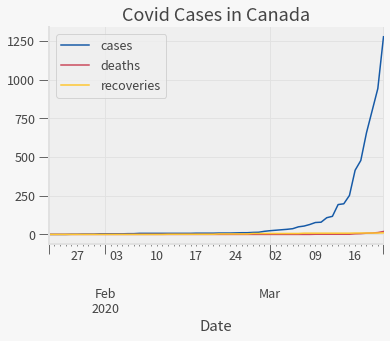

In [7]:
def countryplot(countryname):
    df=covid.groupby("Country/Region").get_group(countryname)
    ax = df.groupby("Date").sum().reset_index().plot(x="Date", y=["cases","deaths","recoveries"], title=f"Covid Cases in {countryname}")
    return(ax)

countryplot("Canada")

Text(0.5, 1.0, 'Cases by Province')

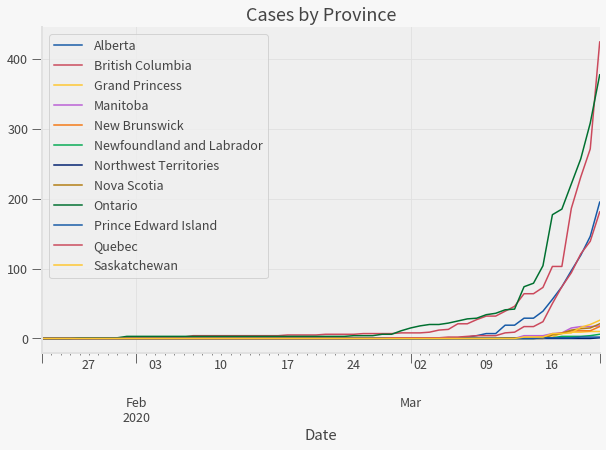

In [8]:
canada = covid.groupby("Country/Region").get_group("Canada")
fig, ax = plt.subplots(figsize=(10,6))
for prov, df in canada.reset_index().groupby("Province/State"):
    df.plot(x="Date",y="cases", ax=ax,label=prov)
ax.set_title("Cases by Province")


<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)

### Comparing Confirmed Case Trajectories

Corona virus began its spread in different areas at different dates.

To compare the growth trajectory of confirmed cases across countries,
we will plot case counts vs the days since the number of cases in an
area reach 50.

In [9]:
# Create column with days since cases reached basecount
basecount=50
baseday = covid.query(f"cases>={basecount}").groupby(["Country/Region","Province/State"])["Date"].min().reset_index().rename(columns={"Date":"basedate"})
df = pd.merge(covid, baseday.reset_index(), on=["Country/Region","Province/State"])
df["dayssince"] = (df["Date"]-df["basedate"]).dt.days;

# To make the plot readable, we'll just show these countries
sdf=df[df["Country/Region"].isin(["Canada","China","Iran","Italy","France","US","Korea, South", "Spain", "United Kingdom"])];

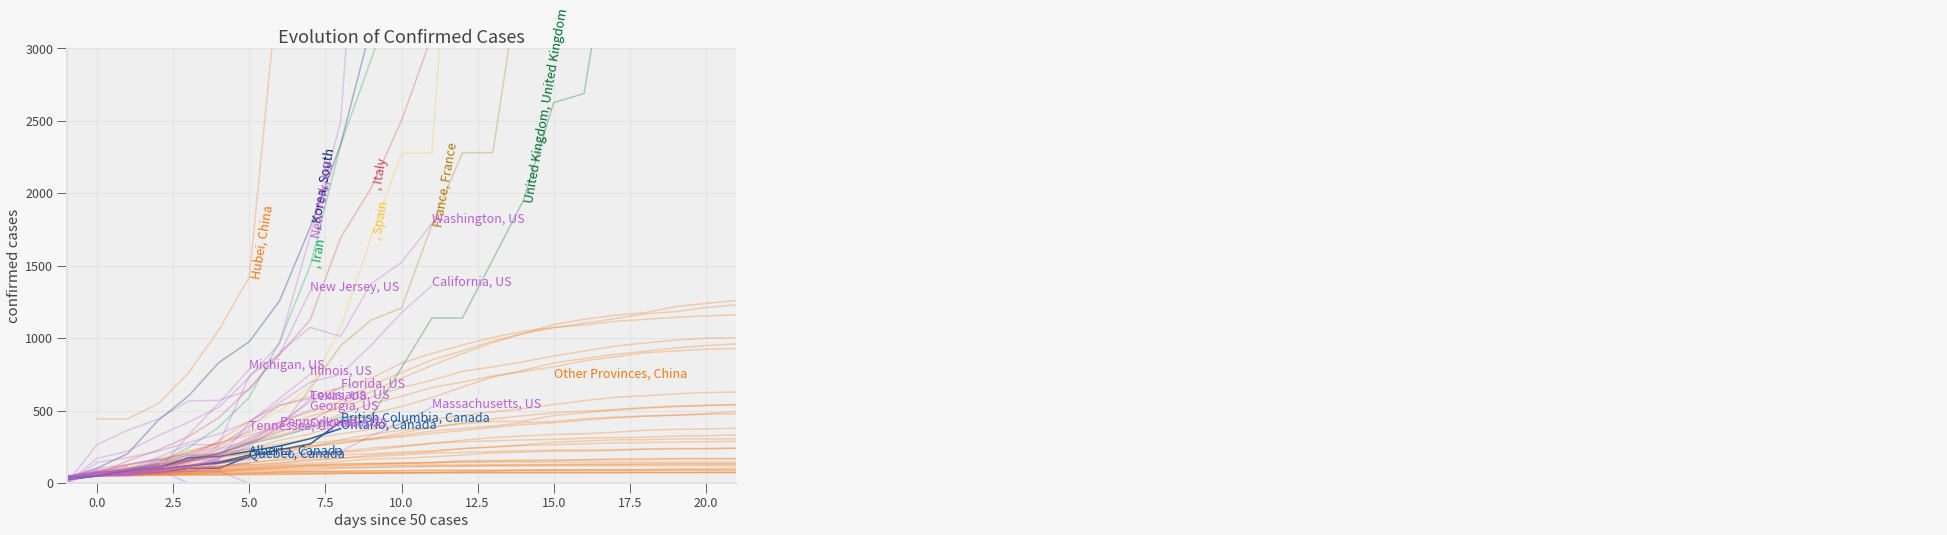

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

ymax = 3000
gdf=sdf.groupby(["Country/Region","Province/State"])
colors = qeds.themes.COLOR_CYCLE
cmap = dict(zip(sdf["Country/Region"].unique(), colors))
for k, g in gdf :
    alpha = 1.0 if k[0]=="Canada" else 0.3
    g.plot(x="dayssince", y="cases", ax=ax, title="Evolution of Confirmed Cases", legend=False, color=cmap[k[0]], xlim=[-1, 21], ylim=[0,ymax], alpha=alpha)
    if g["cases"].max()>=ymax :
        y = ymax*.7
        x = g.query(f"cases<{y}")["dayssince"].max()
        y = g.query(f"dayssince>={x}")["cases"].min()
        ax.annotate(f"{k[1]}, {k[0]}",
        (x, y), rotation=80, color=cmap[k[0]])
    elif g["cases"].max()>=300 or (k[0]=="Canada" and g["cases"].max()>=100):
        x=g["dayssince"].max()
        y=g["cases"].max()
        ax.annotate(f"{k[1]}, {k[0]}", (x,y), color=cmap[k[0]], annotation_clip=True)

ax.annotate("Other Provinces, China", (15,730),color=cmap["China"])
ax.set_xlabel(f"days since {basecount} cases")
ax.set_ylabel("confirmed cases");

From these trajectories, we can get some idea of what might happen in
countries where the epidemic is in its early stages (like Canada) by
looking at what happened in countries where the epidemic is further
along (like China, South Korea, and Italy).

### Mortality

We can get an estimate of the mortality rate by taking deaths divided
confirmed cases. If there are many unconfirmed cases, then we will be
overstating the mortality rate.

Medical care, population comorbidities, and testing availability vary
among countries. This can lead to differences in mortality rate per
confirmed case.

Here are the mortality rates per confirmed case in countries with at
least 50 deaths.

In [11]:
country=covid.groupby(["Country/Region","Date"]).sum()
latest=country.groupby("Country/Region").last().drop(columns=["Lat","Long"])
latest['mortalityrate'] = latest['deaths']/latest['cases']
latest.query('deaths>50')

,cases,deaths,recoveries,mortalityrate
Country/Region,,,,
Belgium,2815,67,263,0.023801
China,81305,3259,71857,0.040084
France,14431,562,12,0.038944
Germany,22213,84,233,0.003782
Iran,20610,1556,7635,0.075497
Italy,53578,4825,6072,0.090056
"Korea, South",8799,102,1540,0.011592
Netherlands,3640,137,2,0.037637
Spain,25374,1375,2125,0.054189


Below is a scatter plot of deaths vs cases. If the mortality rate were
the same across countries, then the points would all be on a line.

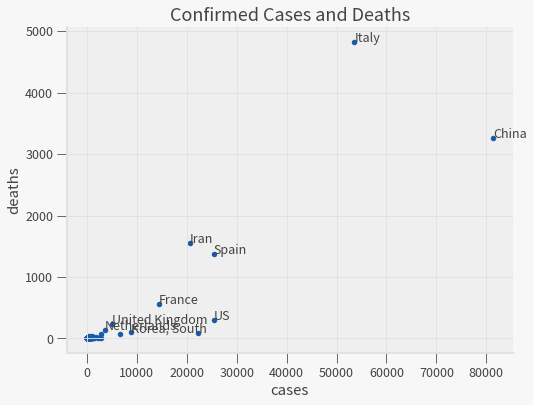

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
latest.plot(x="cases", y="deaths", kind="scatter",title="Confirmed Cases and Deaths", ax=ax)

for r in latest.query('deaths>=100').itertuples():
    ax.annotate(r.Index, (r.cases, r.deaths))

## World Bank Data

We are going to try to predict the spread of Covid from country
characteristics. We will use data from the World Bank, through
the World Bank API from [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/readers/world-bank.html)

World Bank data comes from many sources and is organized into 18 broad
topics. Using `wb.search(field = )` you can search indicators with
specific sources or topics. You can view the list of indicators using
`wb.get_indicators()` and the list of countries by `wb.get_countries()`.
And finally, to download the data you can run `wb.download(country, indicator, start, end)`

Alternatively, there’s a nicely organized table of indicators on [the
World Bank website.](http://wdi.worldbank.org/tables)

We will use the following indicators. You may want to modify them.

In [13]:
# list of indicators we'll use
ind_use = [
    # Population
    "SP.POP.TOTL", "SP.POP.DPND.OL",
    "SP.POP.DPND.YG", "EN.POP.DNST",
    "BG.GSR.NFSV.GD.ZS","SP.URB.GROW",
    "SP.URB.TOTL",
    # Economic
    "NY.GDP.MKTP.KD.ZG", "NY.GDP.PCAP.KD.ZG",
    # Migration & Remittances
    "SM.POP.TOTL", "BX.TRF.PWKR.CD.DT",
    "BM.TRF.PWKR.CD.DT",
    # Tourism
    "ST.INT.ARVL",
    "ST.INT.RCPT.CD",
    "ST.INT.XPND.CD",
    # Health care
    "SH.XPD.CHEX.PC.CD",
    "SH.XPD.OOPC.CH.ZS",
    "SH.MED.PHYS.ZS",
    "SH.MED.NUMW.P3",
    # Health, comorbitites
    "SH.PRV.SMOK.MA",
    "SH.PRV.SMOK.FE",
    "SH.TBS.INCD",
    "SH.STA.DIAB.ZS",
    "SP.DYN.LE00.IN",
    ]

We now download these indicators from World Bank and merge with the Covid data.

In [14]:
import os.path
import warnings

wdifile='./wdi.pkl'
if (os.path.isfile(wdifile)) :
    warnings.warn("Reading WDI data from disk. You probably do not want this if you have modified ind_use.")
    wdi = pd.read_pickle(wdifile)
else :
    def fixcountrynames(s):
        trans = { "Egypt, Arab Rep.":"Egypt",
        "Slovak Republic":"Slovakia",
        "Brunei Darussalam":"Brunei",
        "United States":"US",
        "Iran, Islamic Rep.":"Iran",
        "Korea, Rep.":"Korea, South",
        "Czech Republic":"Czechia",
        "Russian Federation":"Russia",
        "Congo, Dem. Rep.":"Congo (Kinshasa)",
        "Venezuela, RB":"Venezuela",
        "St. Lucia":"Saint Lucia",
        "St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
        "Congo, Rep.":"Republic of the Congo",
        "Bahamas, The":"The Bahamas",
        "Gambia, The":"The Gambia"}
        for t in trans :
            s["Country/Region"] = s["Country/Region"].replace(t, trans[t])
        return(s)

    wdi = covid.drop(columns=["Date","Province/State","Lat","Long","cases","deaths","recoveries"]).drop_duplicates()
    for id in ind_use :
        s=wb.download(indicator=id, country="all", start=2005, end=2019).reset_index()

        # use most recent non missing value
        s=s.dropna().groupby("country").last()
        s=s.drop(columns="year").reset_index()

        # match country names to covid data
        s=s.rename(columns={"country":"Country/Region"})
        s=fixcountrynames(s)
        wdi=pd.merge(wdi, s, how='left', on='Country/Region', validate="one_to_one")
    wdi.to_pickle(wdifile)

In [15]:
cvwdi=pd.merge(country.reset_index(), wdi, how='left', on="Country/Region", validate="many_to_one")
cvwdi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9960 entries, 0 to 9959
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Country/Region     9960 non-null   object        
 1   Date               9960 non-null   datetime64[ns]
 2   Lat                9960 non-null   float64       
 3   Long               9960 non-null   float64       
 4   cases              9960 non-null   int64         
 5   deaths             9960 non-null   int64         
 6   recoveries         9960 non-null   int64         
 7   SP.POP.TOTL        9360 non-null   float64       
 8   SP.POP.DPND.OL     9060 non-null   float64       
 9   SP.POP.DPND.YG     9060 non-null   float64       
 10  EN.POP.DNST        9300 non-null   float64       
 11  BG.GSR.NFSV.GD.ZS  8640 non-null   float64       
 12  SP.URB.GROW        9300 non-null   float64       
 13  SP.URB.TOTL        9300 non-null   float64       
 14  NY.GDP.M

## Predicting growth rates

We will now try to predict the daily growth rate in cases from current
cases and country characteristics. This is similar in spirit to the
informal prediction of case trajectories when we plotted cases versus
days since reaching 50. Our model will predict that countries with
similar characteristics will have similar case growth rates given
current cases.

In [16]:
 def prepdata(cvwdi=cvwdi, lags=0, includedays=True, casemin=0):
     df=cvwdi.set_index("Date")
     df=df.query(f"cases >= {casemin}")
     df["case_growth_rate"]=-df.groupby("Country/Region")["cases"].diff(-1)/df["cases"]

     for l in range(lags) :
         df[f"case_L{l+1}"] = df.groupby("Country/Region")["cases"].shift(l)

     df = df.replace([np.inf, -np.inf], np.nan)
     # Drop indicators that are missing often and/or not useful
     df= df.drop(columns=["Lat","Long"])
     df=df.dropna()
     df = df.reset_index()
     if (includedays):
         df["daysfromstart"] = (df["Date"] - df["Date"].min()).dt.days
     df=df.set_index(["Country/Region","Date"])
     X = df.drop(columns=["case_growth_rate","recoveries","deaths"]).copy()
     for col in list(X):
         X[col] = X[col].astype(float)

     y = df["case_growth_rate"]

     return(X,y)

X, y = prepdata(cvwdi)

Since we our data has a time dimension, and we want to use our model
to predict the future, we should create test and training subsets that
reflect this. Rather than splitting observations randomly (like
`model_selection.train_test_split`), we will use the 3 most
recent days as a test sample and the remaining for training.

In [17]:
from datetime import timedelta

def panel_train_test_split(X,y, testdays=5):
    lastday = X.reset_index()["Date"].max()
    cutoff = lastday - timedelta(days=testdays)
    X_test = X.query(f'Date > "{cutoff}"')
    X_train = X.query(f'Date <= "{cutoff}"')
    y_test = y[X_test.index]
    y_train = y[X_train.index]
    return(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = panel_train_test_split(X,y, testdays=3)
len(y), len(y_train), len(y_test)

(2597, 2273, 324)

To begin with, we will use Lasso to predict growth rates. You may want
to experiment with other prediction methods.

In [18]:
mod=pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    linear_model.LassoCV(cv=5)       # put your favorite model here
)
mod.fit(X_train,y_train)
dict(mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
     mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test)))

{'mse_train': 0.4370858031694549, 'mse_test': 0.36412409982439753}

From the Lasso coefficients, we can somewhat understand the implications for case growth.

In [19]:
lasso_coefs = pd.Series(dict(zip(list(X), mod.steps[1][1].coef_)))
lasso_coefs

cases               -0.010114
SP.POP.TOTL         -0.000000
SP.POP.DPND.OL       0.000000
SP.POP.DPND.YG      -0.000000
EN.POP.DNST         -0.000000
BG.GSR.NFSV.GD.ZS    0.000000
SP.URB.GROW          0.000000
SP.URB.TOTL         -0.000000
NY.GDP.MKTP.KD.ZG    0.000000
NY.GDP.PCAP.KD.ZG   -0.000000
SM.POP.TOTL         -0.000000
BX.TRF.PWKR.CD.DT   -0.000000
BM.TRF.PWKR.CD.DT   -0.000000
ST.INT.ARVL         -0.000000
ST.INT.RCPT.CD      -0.000000
ST.INT.XPND.CD      -0.000000
SH.XPD.CHEX.PC.CD    0.000000
SH.XPD.OOPC.CH.ZS   -0.003883
SH.MED.PHYS.ZS       0.010530
SH.MED.NUMW.P3       0.000000
SH.PRV.SMOK.MA      -0.000000
SH.PRV.SMOK.FE       0.000000
SH.TBS.INCD         -0.000000
SH.STA.DIAB.ZS       0.000000
SP.DYN.LE00.IN       0.000000
daysfromstart        0.068357
dtype: float64

The only features that will vary over time are the date and the number
of cases. We see that we have positive coefficient on date. The growth
rate has tended to increase over time. Note that even with a constant
growth rate, the growth of the number of cases is exponential and will
quickly become extremely large.

However, offsetting the positive date coefficient is a negative
coefficient on cases. As the number of cases increases, the growth
rate slows down. This is a typical feature of models of
epidemics. Eventually everyone who can get infected is infected and
the growth in cases plateaus.  It is somewhat neat that this feature
of epidemiological model shows up in the data just from our simple
prediction model.

### Fit of Predictions

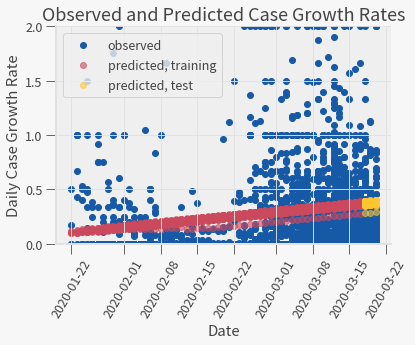

In [20]:
fig, ax = plt.subplots()
tmp = y.reset_index()
ax.scatter(tmp["Date"],tmp["case_growth_rate"], color=colors[0], label='observed')
ax.scatter(X_train.reset_index()["Date"],mod.predict(X_train), color=colors[1],alpha=0.6, label='predicted, training')
ax.scatter(X_test.reset_index()["Date"],mod.predict(X_test), color=colors[2],alpha=0.6, label='predicted, test')
ax.set_ylim((0,2))
ax.legend()
ax.set_title("Observed and Predicted Case Growth Rates")
ax.set_ylabel("Daily Case Growth Rate")
ax.set_xlabel("Date")
ax.xaxis.set_tick_params(rotation=60)

Looking at predicted growth rates vs date, the model seems to be doing
a reasonable job. The predicted growth rates are within a reasonable
range. Notice the general increasing trend in growth rates. This will
make the longer term predictions of the model look quite dire.

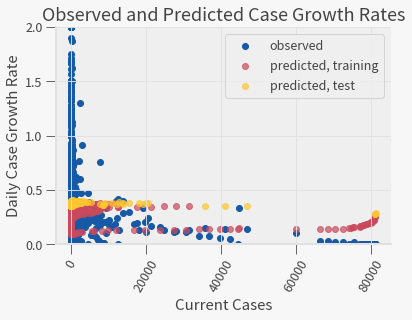

In [21]:
fig, ax = plt.subplots()
ax.scatter(X["cases"],y, color=colors[0],label='observed')
ax.scatter(X_train["cases"],mod.predict(X_train), color=colors[1],alpha=0.7,label='predicted, training')
ax.scatter(X_test["cases"],mod.predict(X_test), color=colors[2], alpha=0.7, label='predicted, test')
ax.legend()
ax.set_ylim((0,2))
ax.set_title("Observed and Predicted Case Growth Rates")
ax.set_ylabel("Daily Case Growth Rate")
ax.set_xlabel("Current Cases")
ax.xaxis.set_tick_params(rotation=60)

The fit of predictions versus current cases are not quite so good. We
see that the model often overpredicts growth rates for cases between
roughly one and ten thousand. This is likely driven by the few large
growth rates that can occur with very few cases. Our model might be
improved by letting current cases enter more flexibly.

### Predicted Case Trajectories

Our model gives a prediction of the growth rate of cases from today to
tomorrow as a function of current cases and country
characteristics. We can use the model to predict cases multiple days
into the future by repeatedly predicting growth given cases, updating
cases, and repeating.

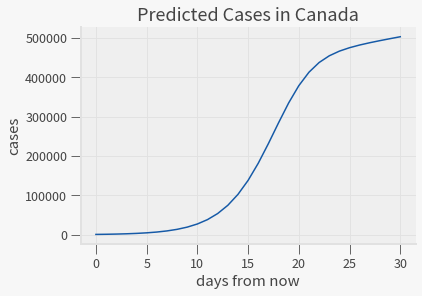

In [22]:
 def predict_path(x0, mod, days=28):
     x = x0
     y = np.zeros(days+1)
     y[0] = x["cases"]
     for d in range(days) :
         y[d+1] = (mod.predict(x)+1)*x["cases"]
         # update x
         l = 1
         while (f"cases_L{l}" in x.columns):
             if l==1 :
                 x[f"cases_L{l}"] = x["cases"]
             else :
                 x[f"cases_L{l}"] = x[f"cases_L{l-1}"]
             l = l+1
         x["cases"]=y[d+1]
         if ("daysfromstart" in x.columns):
             x["daysfromstart"]=x["daysfromstart"]+1

     fig, ax = plt.subplots()
     ax.plot(range(len(y)),y)
     ax.set_title(f"Predicted Cases in {country}")
     ax.set_xlabel('days from now')
     ax.set_ylabel('cases')
     return(y, fig, ax)

country="Canada"
yhat, fig, ax=predict_path(X.xs(country).tail(1).copy(), mod, days=30)

Note that we are taking a model trained to predict one day ahead and
using it to predict 30 days into the future. This is asking an awful
lot of the model. Also, we have seen above some obvious deficiencies
in model fit. Therefore, these predictions come with some large
caveats. Nonetheless, they do give some idea how the number of cases
might grow if Corona virus spreads in Canada in a similar way to it
has elsewhere.


<a id='exercise-1'></a>
> See exercise 2 in the [*exercise list*](#exerciselist-0)



<a id='exercise-2'></a>
> See exercise 3 in the [*exercise list*](#exerciselist-0)

## More Detailed Data

China was the first country hit by COVID-19. After two months of lockdown,
there are almost no new cases anymore. Therefore we might learn more about
the complete COVID-19 epidemic dynamics by looking into Chinese panel data.

JHU CSSE collects data on province/state level for different countries
across the world which forms an unbalanced panel. In particular,
JHU CSSE gathered Chinese data from [DingXiangYuan](https://ncov.dxy.cn/ncovh5/view/en_pneumonia)
(DXY, it means “clove garden” in Chinese) starting from Jan 21st.
However, DXY manually collects more detailed prefecture- or city-level
data and some open-source web crawlers are updating these data every half
hour. We can utilize this panel data for further analysis.

In [23]:
# Use the city-level web crawler data form DingXiangYuan (DXY)
dt_china = pd.read_csv('https://raw.githubusercontent.com/BlankerL/DXY-COVID-19-Data/master/csv/DXYArea.csv')

# DXY collects data around the world but we use the Chinese data only
dt_china = dt_china[dt_china["countryEnglishName"] == "China"]
# Convert string to datetime
dt_china["updateTime"] = pd.to_datetime(dt_china["updateTime"])
# Drop NaN and unknown area reports on city level
dt_china = dt_china.dropna(subset = ["cityEnglishName"])
dt_china = dt_china[dt_china["cityEnglishName"] != "Area not defined"]

dt_china.head()

,continentName,continentEnglishName,countryName,countryEnglishName,provinceName,provinceEnglishName,province_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,updateTime,cityName,cityEnglishName,city_zipCode,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount
331,亚洲,Asia,中国,China,重庆市,Chongqing,500000,577,1.0,570,6,2020-03-22 18:52:13,万州区,Wanzhou District,500101.0,118.0,0.0,114.0,4.0
332,亚洲,Asia,中国,China,重庆市,Chongqing,500000,577,1.0,570,6,2020-03-22 18:52:13,江北区,Jiangbei District,500105.0,28.0,0.0,28.0,0.0
333,亚洲,Asia,中国,China,重庆市,Chongqing,500000,577,1.0,570,6,2020-03-22 18:52:13,云阳县,Yunyang County,500235.0,25.0,0.0,25.0,0.0
334,亚洲,Asia,中国,China,重庆市,Chongqing,500000,577,1.0,570,6,2020-03-22 18:52:13,合川区,Hechuan District,500117.0,23.0,0.0,23.0,0.0
335,亚洲,Asia,中国,China,重庆市,Chongqing,500000,577,1.0,570,6,2020-03-22 18:52:13,綦江区,Qijiang District,500110.0,23.0,0.0,23.0,0.0


Since DXY provides both Chinese and English webpages, the scraped data
consists of variables in both languages. We will use the English ones.
There are four variables of main interest: confirmed cases, suspected cases,
cases that are cured, and mortality.

## Visualization, continued

For most of the European and North American data we observe the expanding
trajectories. COVID-19 spreads out exponentially. We plot some similar
trajectories with Chinese data. Below we plot a trajectory for all cities
in the same province.

Text(0, 0.5, 'Persons')

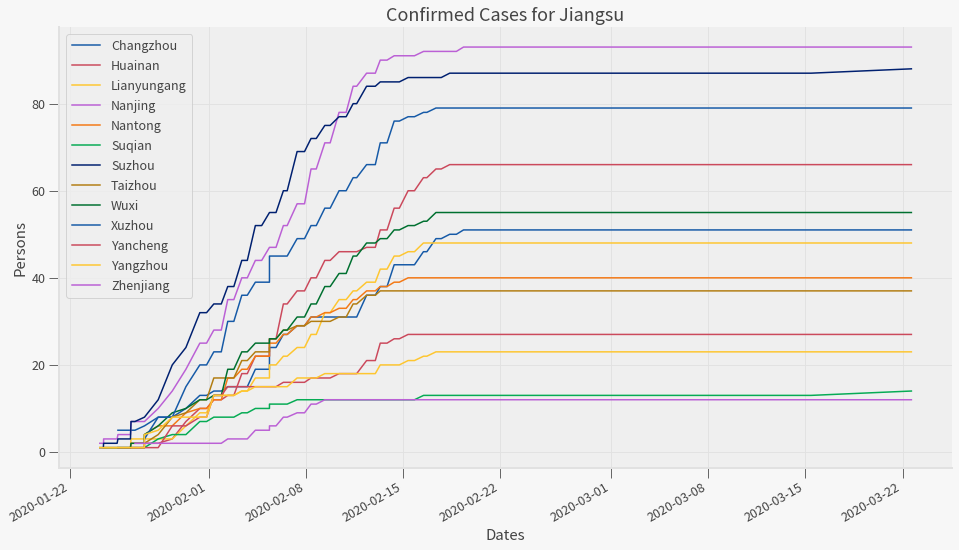

In [24]:
province_name = "Jiangsu" # For Jiangsu Province, you can change to "Hubei", "Shanghai", etc.
cur_province = dt_china.groupby("provinceEnglishName").get_group(province_name)
fig, ax = plt.subplots(figsize=(16,9))
for city, df in cur_province.reset_index().groupby("cityEnglishName"):
    df.plot(x="updateTime",y="city_confirmedCount", ax = ax, label = city)

# ax.legend().set_visible(False)
ax.set_title(f"Confirmed Cases for {province_name}")
ax.set_xlabel("Dates")
ax.set_ylabel("Persons")

We can see that the growth rate is high at the beginning, and then the growth
slows down. Eventually those trajectories converge, meaning that there are
no new confirmed cases any more.

Now let’s have a look at Hubei province (Wuhan is the capital of Hubei province
and most of the economic activities in Hubei are associated with Wuhan).

Text(0, 0.5, 'Persons')

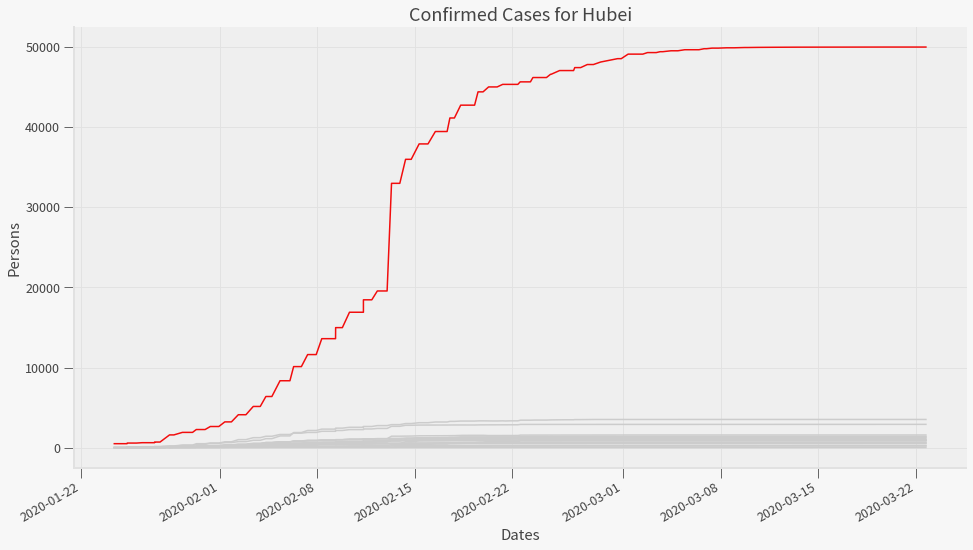

In [25]:
province_name = "Hubei"
cur_province = dt_china.groupby("provinceEnglishName").get_group(province_name)

# Use different color to emphasize
emp_color = (0.95, 0.05, 0.05)
nom_color = (0.8, 0.8, 0.8)

fig, ax = plt.subplots(figsize=(16,9))
for city, df in cur_province.reset_index().groupby("cityEnglishName"):
    if (city == "Wuhan"):
        cur_color = emp_color
    else:
        cur_color = nom_color
    df.plot(x="updateTime",y="city_confirmedCount", ax = ax, label = city, color = cur_color)

ax.legend().set_visible(False)
ax.set_title(f"Confirmed Cases for {province_name}")
ax.set_xlabel("Dates")
ax.set_ylabel("Persons")

Hubei stands out compared to other provinces from our previous graph, and
Wuhan stands out within Hubei province. Notice that there is a sudden jump
on Feb 13th. Do you know why? Wuhan starts lockdown from late January,
therefore the sudden jump doesn’t make much sense.

The reason behind this sudden jump is that the Chinese CDC changes its measure
for confirmed cases. Since COVID-19 lab tests take 2-3 days which might be
slow, the Chinese CDC includes all clinically diagnosed cases (mostly through
Computed Tomography scans) as confirmed cases. This measure overestimates the
confirmed cases by a small amount.

Therefore, a drastic change in data might be some interesting phenomenon,
but it could also be just a change in measurement.

### Curve in “Flatten the Curve”

You might have heard the phrase “flatten the curve” frequently these days.
In epidemiology, the idea of slowing a virus’ spread so that fewer people
need to seek treatment at any given time, which brings less burden to the
whole medical system. That’s why so many countries are implementing
“social distancing” and “shelter in place” orders.

To “flatten the curve”, we first analyze the curve itself. Essentially,
the curve characterizes how many confirmed cases that are not cured yet.

Text(0.5, 0, 'Time')

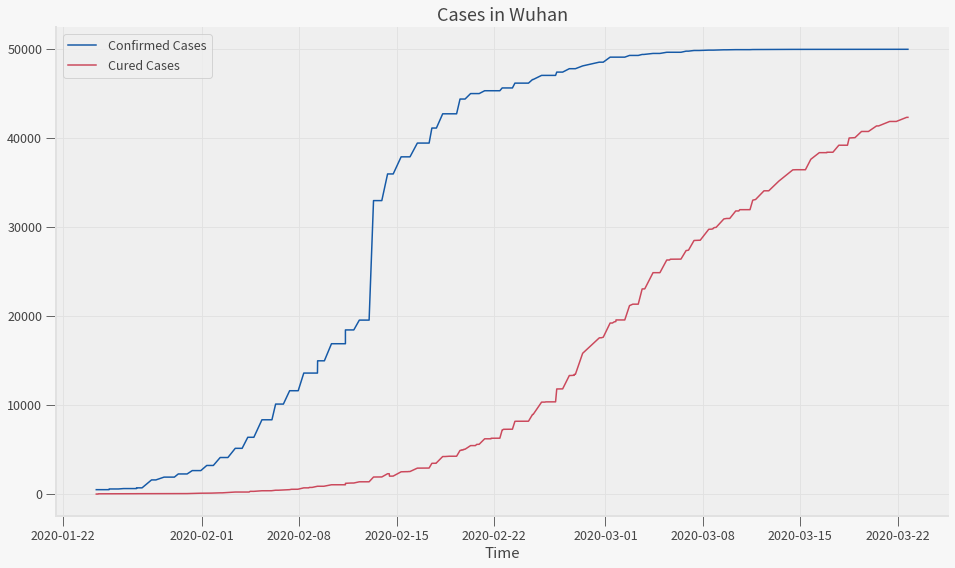

In [26]:
# Plot Wuhan out
dt_wuhan = dt_china[dt_china["cityEnglishName"] == "Wuhan"]
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(dt_wuhan["updateTime"], dt_wuhan["city_confirmedCount"], label = "Confirmed Cases")
ax.plot(dt_wuhan["updateTime"], dt_wuhan["city_curedCount"], label = "Cured Cases")

ax.legend()
ax.set_title('Cases in Wuhan')
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

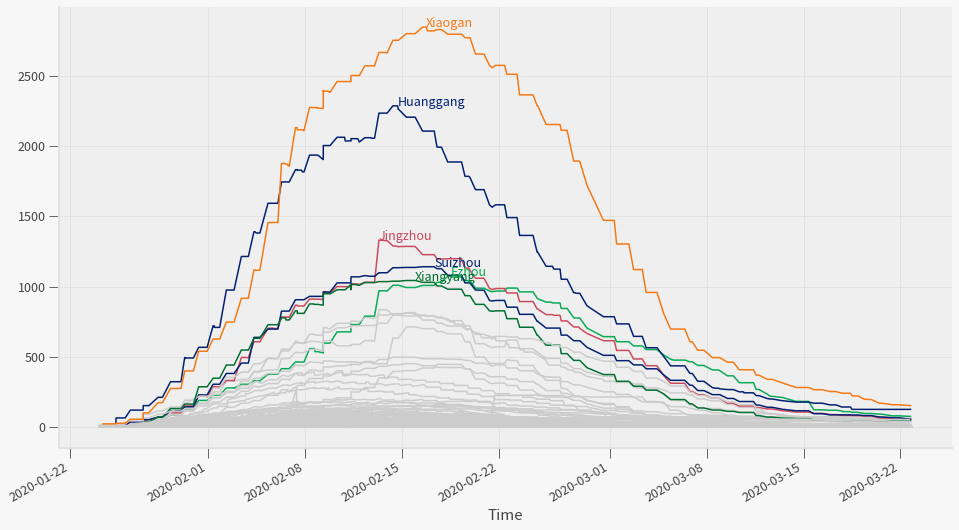

In [27]:
# Compute current cases
# Compute current cases
dt_china["city_current"] = dt_china["city_confirmedCount"] - dt_china["city_curedCount"]

colors = qeds.themes.COLOR_CYCLE
cmap = dict(zip(dt_china["cityEnglishName"].unique(), colors * (int(len(dt_china["cityEnglishName"].unique()) / 7) + 1)))
nom_color = (0.8, 0.8, 0.8)

fig, ax = plt.subplots(figsize=(16,9))
# dt_hubei = dt_china.groupby("provinceEnglishName").get_group("Hubei")
for city, df in dt_china.reset_index().groupby("cityEnglishName"):
    if (city != "Wuhan"):
        if (df["city_current"].max() >= 1000):
            df.plot(x="updateTime",y="city_current", ax = ax, label = city, color = cmap[city])
            y = df["city_current"].max()
            x = df["updateTime"][df["city_current"].idxmax()]
            ax.annotate(f"{city}", (x,y), color=cmap[city], annotation_clip=True)
        else:
            df.plot(x="updateTime",y="city_current", ax = ax, label = city, color = nom_color)

ax.legend().set_visible(False)
ax.set_xlabel("Time")


<a id='exercise-3'></a>
> See exercise 4 in the [*exercise list*](#exerciselist-0)

## References

## Exercises


<a id='exerciselist-0'></a>
**Exercise 1**

Visualize the evolution of cases in other countries and their provinces or states.

In [28]:
# your code here

([*back to text*](#exercise-0))

**Exercise 2**

Examine the model's predictions for other countries.

In [29]:
# your code here

([*back to text*](#exercise-1))

**Exercise 3**

Try pedicting case growth rates with other regression methods.

In [30]:
# your code here

([*back to text*](#exercise-2))

**Exercise 4**

Plot the trajectory for all cities other than Wuhan in Hubei province.
Compare the magnitudes of confirmed cases in Hubei province to other
provinces (e.g. Jiangsu above)

In [31]:
# your code here

([*back to text*](#exercise-3))